# Fine tuned BERT Classifier

Imports and loading data

install these libraries
```
pip install transformers datasets scikit-learn torch
```

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split

fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

fake_df['label'] = 0
true_df["label"] = 1

In [2]:
print(true_df['label'].value_counts())
print(fake_df['label'].value_counts())

label
1    21417
Name: count, dtype: int64
label
0    23481
Name: count, dtype: int64


## Pre-processing

In [3]:
import re

# Removes urls and extra spaces
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Removing rows with missing values in title or text
fake_df.dropna(subset=['title', 'text'], inplace=True)
true_df.dropna(subset=['title', 'text'], inplace=True)

# Combining title and text 
fake_df['text'] = fake_df['title'] + ". " + fake_df['text']
true_df['text'] = true_df['title'] + ". " + true_df['text']

fake_df['text'] = fake_df['text'].apply(clean_text)
true_df['text'] = true_df['text'].apply(clean_text)

# Final dataframe with cleaned text and label
df = pd.concat([fake_df[['text', 'label']], true_df[['text', 'label']]], ignore_index=True)
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df.head()

,text,label
0,HOW NEWSWEEK ACCUSES Melania and Ivanka Of Sen...,0
1,France to lead investigation into A380 engine ...,1
2,Trump’s Star May Be Removed From The Hollywood...,0
3,Twitter bans ads from two Russian media outlet...,1
4,‘THE DUCK MAN’ Has Spoken: DUCK DYNASTY’S Patr...,0


# Train test split
We use a split of 70/15/15 for training, validation, and testing

In [5]:
from sklearn.model_selection import train_test_split

# Split into train and temp (val+test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.3, random_state=42, stratify=df['label']
)

# Split temp into val and test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=42, stratify=temp_labels
)

## Tokenization 

In [17]:
from transformers import BertTokenizer
import torch
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])


val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])


In [ ]:
# Create a custom dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
train_dataset = NewsDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = NewsDataset(val_input_ids, val_attention_mask, val_labels)
test_dataset = NewsDataset(test_input_ids, test_attention_mask, test_labels)


## Training

This is where we fine tune our model for use in our data.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Where to save model
    eval_strategy="steps",
    eval_steps=1000,      
    save_steps=1000,                 # Save checkpoint each 1000 steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir='./logs',            # Logs for TensorBoard
    learning_rate=2e-5,
    weight_decay=0.01,          # Regularization
    logging_steps=50, 
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    fp16=True,                       # Mixed precision for faster training
)

In [28]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

In [29]:
from transformers import BertForSequenceClassification, Trainer

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
1000,0.015700,0.005282,0.999258
2000,0.000000,0.007967,0.999109
3000,0.000000,0.005860,0.999406
4000,0.000000,0.005714,0.999406
5000,0.000000,0.004932,0.999406
6000,0.021800,0.003677,0.999406
7000,0.000000,0.004170,0.999555


TrainOutput(global_step=7858, training_loss=0.005304685323770552, metrics={'train_runtime': 633.5699, 'train_samples_per_second': 99.209, 'train_steps_per_second': 12.403, 'total_flos': 4134527123927040.0, 'train_loss': 0.005304685323770552, 'epoch': 2.0})

## Save model

In [ ]:
model.save_pretrained("saved_model/")

## Testing + Metrics

In [32]:
# model = BertForSequenceClassification.from_pretrained("saved_model/")
from sklearn.metrics import accuracy_score, classification_report

preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(-1)
print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.9997030438010394
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



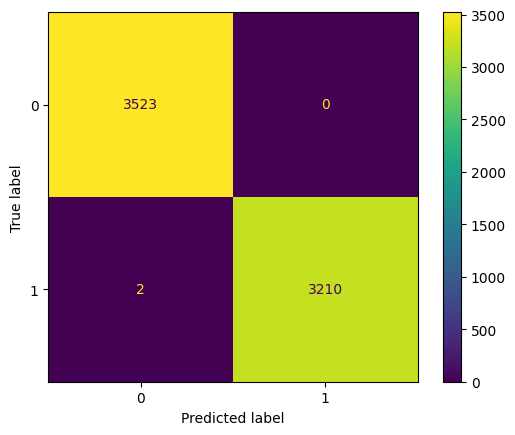

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)